# Robust MPC

We want to implement the worst-case robust MPC example from the lecture from Slide 6. We have the following LTI dynamics

$$ x_{k+1} = x_k + u_k + w_k$$

with $x_k \in \mathbb{R}$ and $u_k \in \mathbb{R}$.
Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{min}_{u,x} & \sum_{k=0}^{K-1} x_k^2 + u_k^2\\
\mbox{s.t.} & x_{k+1} = x_k + u_k + w_k\\%, \quad k=0, \ldots, K-1\\
& | x_k|\leq 1, \quad x_0 = 1.
\end{array}

It is enough to implement the constraints for the worst-case noise realizations, so $w_{max} = [0.5,0.5, 0.5, 0.5....]$ and $w_{min} = [-0.5,-0.5, -0.5, -0.5....]$.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import random

In [2]:


#%% Feedback MPC
n_x, n_u = 1, 1
K = 5
A = 1
B = 1
q = 1
r = 1
T = 30


# Maximum disturbance values, as the set is not time-varying these are constant for all k = 0,..., K
w_min = -0.5
w_max = 0.5

x_0 = np.array(1)

x_realized_traj = np.zeros([n_x, T+1])
x_realized_traj[:, 0] = x_0
u_traj =  np.zeros([n_u, T])

for t in range(T):

    x_nom = cp.Variable((1, K + 1))
    x_min = cp.Variable((1, K + 1))
    x_max = cp.Variable((1, K + 1))
    u = cp.Variable((1, K))

    cost = 0
    constr = []
    for k in range(K):
        cost += cp.quad_form(x_nom[:,k],q*np.eye(n_x)) + cp.quad_form(u[:,k],r*np.eye(n_u))

        constr += [x_nom[:, k + 1] == A * x_nom[:, k] +  B * u[:, k] ,
                   x_min[:, k + 1] == A * x_min[:, k] + B * u[:, k] + w_min ,
                   cp.norm(x_min[:, k], 1) <= 1,
                   x_max[:, k + 1] == A * x_max[:, k]+  B * u[:, k] + w_max,
                   cp.norm(x_max[:, k], 1) <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x_min[:, 0] == x_0, x_max[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = True)

    if problem.status == "infeasible_inaccurate":
        print("###################")
        print("Problem is infeasible.")
        print("###################")
        break

    w_realized = random.uniform(w_min, w_max)
    x_0 = A * x_0 + B * u[:,0].value + w_realized

    u_traj[:, t] = u[:,0].value
    x_realized_traj[:, t+1] = x_0





                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 12 10:05:29 AM: Your problem has 23 variables, 27 constraints, and 0 parameters.
(CVXPY) Apr 12 10:05:29 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 10:05:29 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 12 10:05:29 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 12 10:05:29 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 10:05:29 AM: Compiling problem (target solver=OSQP).
(CV

/opt/conda/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


**Question 1:**

Can you find an initial state for which the robust MPC problem above is feasible? Why not? Why can the MPC not solve this simple problem?

**Answer 1:**

No, for a prediction horizon of $K=5$, noise of $|w_k|\leq0.5$ and state constraints of $|x_k|\leq1$ there exists no initial condition for which the open loop problem is feasible. A simple exmaple is the following, the mid point of the two limits is $x_0= 0$. If we assume the worst case disturbance acts upon the system it would be at $x_5 = \sum_{k=0}^{4} u_{k} + 5 \,w_k$, which for the positive disturbance would be $x_5 = \sum_{k=0}^{4} u_{k} + 2.5$ and for the negative it would be $x_5 = \sum_{k=0}^{4} u_{k} - 2.5$. So there is no control which could jointly keep the system within the state constraints as the control input cannot be positive and negative at the same time. The same input would have to ensure constraint satisfaction for both state trajectory realizations.

# Feedback MPC

Now using the same example from the lecture, we want to design a feedback MPC policy
\begin{equation}
\pi_k(x_k, \mathbf{v})=v_k + L x_k
\end{equation}
wich renders the optimal control problem above feasible.

We use the same worst-case approach, but cancel some of the effect of the disturbance using the state-feedback.

In [3]:
#%% Feedback MPC
n_x, n_u = 1, 1

K = 5
A = 1
B = 1
q = 1
r = 1
L = -1


# Maximum disturbance values, as the set is not time-varying these are constant for all k = 0,..., K
w_min = -0.5
w_max = 0.5

x_0 = np.array(1)

x_realized_traj = np.zeros([n_x, T+1])
x_realized_traj[:, 0] = x_0
v_traj =  np.zeros([n_u, T])
u_traj =  np.zeros([n_u, T])


for t in range(T):

    x_nom = cp.Variable((1, K + 1))
    x_min = cp.Variable((1, K + 1))
    x_max = cp.Variable((1, K + 1))
    v = cp.Variable((1, K))

    cost = 0
    constr = []
    for k in range(K):
        #policy
        pi_min = v[:,k] + L*x_min[:,k]
        pi_max = v[:,k] + L*x_max[:,k]
        pi_nom = v[:,k] + L*x_nom[:,k]

        cost += cp.quad_form(x_nom[:,k],q*np.eye(n_x)) + cp.quad_form(pi_nom,r*np.eye(n_u))
        constr += [x_nom[:, k + 1] == A * x_nom[:, k] +  B * pi_nom ,
                   x_min[:, k + 1] == A * x_min[:, k] +  B * pi_min + w_min ,
                   cp.norm(x_min[:, k], 1) <= 1,
                   x_max[:, k + 1] == A * x_max[:, k]+ B * pi_max + w_max,
                   cp.norm(x_max[:, k], 1) <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x_min[:, 0] == x_0, x_max[:, 0] == x_0, x_nom[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False)

    if problem.status == "infeasible_inaccurate":
        print("###################")
        print("Problem is infeasible.")
        print("###################")
        break

    w_realized = random.uniform(w_min, w_max)
    x_0 = (A + B*L) * x_0 + B * v[:,0].value + w_realized

    v_traj[:, t] = v[:,0].value
    u_traj[:, t] = v_traj[:, t] + L*x_0
    x_realized_traj[:, t+1] = x_0

**Question 2:**

For which values of the state-feedback gain $L$ and initial values $x_0$ is the Feedback MPC problem above feasible? Explain, why is it not feasible, for $L= 0.25$ and $x_0 = 0$ ?

You can plot the outputs below.


**Asnwer 2:**

For $L=-1$ the Feedback MPC problem is feasible for any initial state $|x_0|\leq 1$. And also for other combinations of feedback gains and states, for example $L=-0.5 $ and $x_0=0$. The state evolution is

\begin{equation}
x_5 = (1+L)^{5} x_0 + \sum_{k=0}^4(1+L)^{4-k} (u_k+w_k)
\end{equation}


which you can check leads to an empty constraint set for $L=-0.25$ as described in Answer 5.

Text(0.5, 0, '$t$')

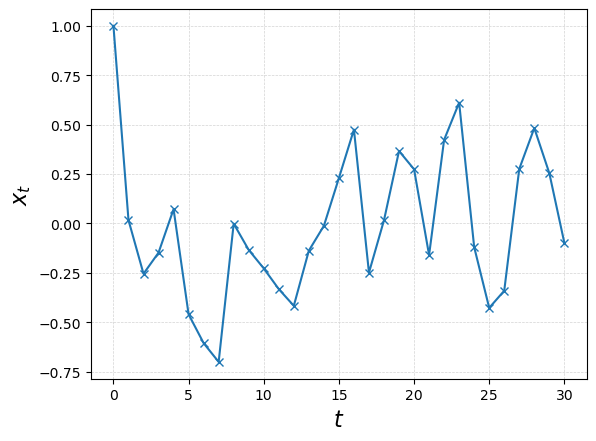

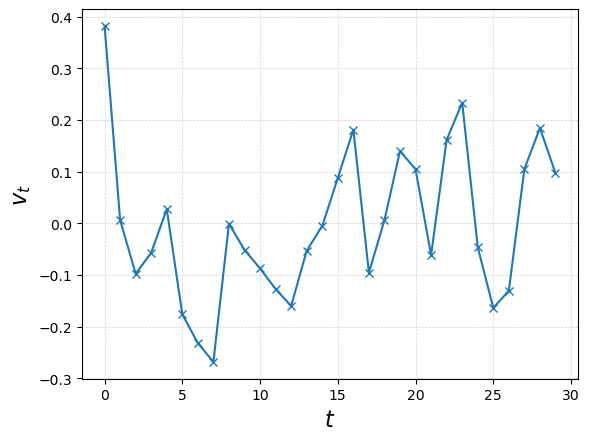

In [4]:
# Plotting
f1 = plt.figure()
plt.plot(x_realized_traj[0,:], marker = 'x')


plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$x_t$", fontsize=16)




f2 = plt.figure()

plt.plot(v_traj[0,:].round(4), marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.ylabel("$v_t$", fontsize=16)
plt.xlabel("$t$", fontsize=16)

General note if the disturbances come from a probability distribution:

This "worst-case" robust approach only works for disturbances coming from bounded distributions, where you would take the the max and min bounds of the distribution and apply the same procedure. Note however that such a robust approach does not take into account the likelihood of disturbance realizations at the boundary. If you do have information about the probability distribution of the disturbance then it is best to incoporate that information in your control problem (we did not cover this in the course). Without having access to that information (or using it) we can still ensure constraint satisfaction at all times but it will lead to conservative solutions and feasibility issues as we have seen in the exercises above. In some applications it is preferable to work with probabilistic constraints ("chance constraints") but this is not covered in the course. See this article for further reading:

A. Mesbah, "Stochastic Model Predictive Control: An Overview and Perspectives for Future Research," in IEEE Control Systems Magazine, vol. 36, no. 6, pp. 30-44, Dec. 2016, doi: 10.1109/MCS.2016.2602087.

# Economic MPC vs Tracking MPC

We have the following LTI dynamics

$$ x_{k+1} = A\, x_k + B \,u_k  = \left[\begin{smallmatrix} 0.857 & 0.884 \\ -0.0147& -0.0151 \end{smallmatrix}\right] x_k + \left[\begin{smallmatrix}  8.57\\ 0.884\end{smallmatrix}\right] u_k.$$

with $x_k \in \mathbb{R}^2$ and $u_k \in \mathbb{R}$.
Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{minimize} & \sum_{k=0}^{K-1} g(x_k, u_k)\\
\mbox{subject to} & x_{k+1} = Ax_k + Bu_k\\%, \quad k=0, \ldots, K-1\\
& \| u_k\|_{\infty}\leq 1, \quad x_0 = \left[\begin{smallmatrix} 80 \\ 10 \end{smallmatrix}\right].
\end{array}

Where the tracking MPC has the following cost function:
\begin{equation}
g_{tr}(x_k, u_k) = \|x_k -x_s \|^2_Q + \| u_k -u_s\|_R^2
\end{equation}
with $Q = \left[\begin{smallmatrix} 2& 0 \\ 0 & 2 \end{smallmatrix}\right]$ and $R = 2$.

The economic MPC has the following economic cost function:

\begin{equation}
g_{e}(x_k, u_k) = q^T x_k + r\, u_K
\end{equation}

with $q =  \left[\begin{smallmatrix}  -3\\-2\end{smallmatrix}\right]$ and $r = -2$.

(Note: The first part of the exercise follows Example 2.57 on page 158 of the recommended MPC textbook from Rawlings et al. The cost function parameters, dynamics and constraints are differetn though.)

In [5]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


n_x, n_u = 2,1

A = np.array([[0.857 ,0.884], [-0.0147, -0.0151]])
B = np.array([8.57, 0.884])
T = 30
K= 7


### Exercise 1:

Compute the economically optimal steady state and input pair $x_s$ and $u_s$.

In [6]:
#%% Solve steady-state problem with economic cost and input constraints

x_s = cp.Variable((n_x, 1))
u_s = cp.Variable((n_u, 1))

r = -2
q = np.array([-3,-2])

cost = 0
constr = []

cost +=  q @ x_s[:, 0] + r * u_s[:, 0]
constr += [x_s[:, 0] == A @ x_s[:,0] + B * u_s[:, 0], cp.norm(u_s[:, 0], 'inf') <= 1]

# sums problem objectives and concatenates constraints.

problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(verbose = False)

x_s = x_s.value.round().reshape(-1,)
u_s = u_s.value.round().reshape(-1,)

print('The economically optimal steady-state input is:'+ str(u_s))
print('The economically optimal steady state is:'+ str(x_s))

The economically optimal steady-state input is:[1.]
The economically optimal steady state is:[60.  0.]


### Exercise 2:

Fill in the lines of code below for the tracking MPC and the economic MPC. Compare the two outputs and answer the questions.

In [7]:
#%%
n_x, n_u = 2,1
Q = 2*np.eye(n_x)
R = 2

x_0 = np.array([80,10])

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  cp.quad_form(x[:, k] - x_s,Q) + R * (u[:, k]- u_s)**2
        constr += [x[:, k + 1] == A @ x[:, k] + B * u[:, k], cp.norm(u[:, k], 'inf') <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False,solver=cp.SCS )

    x_0 = A @ x_0 + B * u[:,0].value

    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0

u_tra = u_traj.copy()
x_tra = x_traj.copy()

In [8]:
r = -2
q = np.array([-3,-2])

x_0 = np.array([80,10])

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  q @ x[:, k] + r * u[:, k]
        constr += [x[:, k + 1] == A @ x[:, k] + B * u[:, k], cp.norm(u[:, k], 'inf') <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False)

    x_0 = A @ x_0 + B * u[:,0].value

    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0

u_eco = u_traj.copy()
x_eco = x_traj.copy()

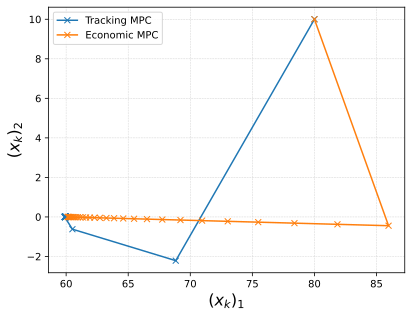

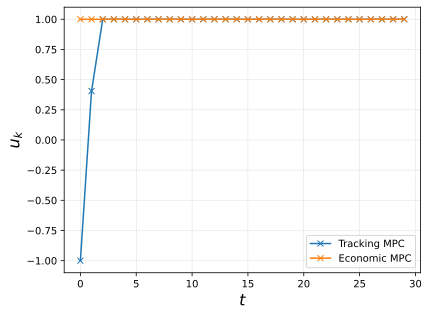

In [9]:
%config InlineBackend.figure_format = 'svg'

f1 = plt.figure()

plt.plot(x_tra[0,:], x_tra[1,:], marker = 'x')
plt.plot(x_eco[0,:], x_eco[1,:], marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['Tracking MPC', 'Economic MPC'])

f2 = plt.figure()

plt.plot(u_tra[0,:], marker = 'x')
plt.plot(u_eco[0,:], marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.ylabel("$u_k$", fontsize=16)
plt.xlabel("$t$", fontsize=16)
plt.legend(['Tracking MPC', 'Economic MPC'])

**Question 3:**

Why is the output of the economic MPC different to the tracking MPC?

**Answer 3:**

The tracking MPC cost only penalizes the distance to steady-state input and the steady state and thus tries to reach it quickly. Whereas the economic cost in the EMPC is trying to maximize input and state and therefore stay longer in the area with the higher state and the converges to the steady state following the stable dynamics always applying the maximal input $u_s=1$ as this is "economically" optimal.

**Question 4:**

Which of the two controller give the lower **economic** cost?

**Answer 4:**

The EMPC controller as it not only converges to the economically optmial steady state but also optimizes the cost along the transient phase while the system is converging from the initial state to the steady state.

**Question 5:**

Why does the economic MPC converge to the optimal steady state of the system if there is no terminal state constraint to do so?

**Answer 5:**

The EMPC cost is trying to maximize input and states of the system which can be achieved by applying the maximal input $u=1$. Thus, the EMPC controller continuously applies the input of $u=1$ and then overtime (following the dynamics of the system) converges to the corresponding steady state $x_0 = \left[\begin{smallmatrix} 60 \\ 0 \end{smallmatrix}\right]$.

**Question 6:**

Can you modifiy the cost matrices of the tracking MPC problem such that the two outputs match?

**Answer 6:**

Yes in this example, with a linear cost and only input constraints, the trajectories of the two systems conicide for $Q = \left[\begin{smallmatrix} 0& 0 \\ 0 & 0 \end{smallmatrix}\right]$. In this case the tracking MPC only penalizes the distance to the steady-state input and also applies a constant input $u = u_s =1$ which is the same as the input of the EMPC.